Student IDs: 1043258, XXXXXX
Student Names: Jun Li Chen, XXX

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import secrets
import glob
from tqdm import *
from random import randint
import time

path = "Dataset\\"
files = os.listdir(path)
files = [files[i:i + 3] for i in range(0, len(files), 3)]

In [2]:
def sum_square_diff(val1, val2):
    if val1.shape != val2.shape:
        return 0
    return np.sum((val1 - val2) ** 2)

def sum_abs_diff(val1, val2):
    if val1.shape != val2.shape:
        return 0
    return np.sum(abs(val1 - val2))

def norm_cross_cor(val1, val2):
    if val1.shape != val2.shape:
        return 0
    return np.sum(np.multiply(val1, val2)) / np.multiply(np.sqrt(np.sum(val1 ** 2)), np.sqrt(np.sum(val2 ** 2)))

def zero_mean_sum_abs_diff(val1, val2):
    if val1.shape != val2.shape:
        return 0
    return np.sum(abs(val1 - np.average(val1) - val2 + np.average(val2)))

In [3]:
def compare_blocks(y, x, l_block, r_img, block_size, search_size, func):
    x_min = max(0, x - search_size)
    x_max = min(r_img.shape[1], x + search_size)
    min_val = math.inf
    min_index = None
    for i in range(x_min, x_max):
        r_block = np.asarray(r_img[y: y+block_size, 
                                   i: i+block_size])
        val = func(l_block, r_block)
        if val <= min_val:
            min_val = val
            min_index = (y, i)
    return min_index

def compare_blocks2(y, x, l_block, r_img, block_size, search_size, func):
    x_min = max(0, x - search_size)
    x_max = min(r_img.shape[1], x + search_size)
    max_val = -math.inf
    max_idx = None
    for i in range(x_min, x_max):
        r_block = r_img[y: y+block_size, 
                        i: i+block_size]
        val = func(l_block, r_block)
        if val >= max_val:
            max_val = val
            max_idx = (y, i)
    return max_idx

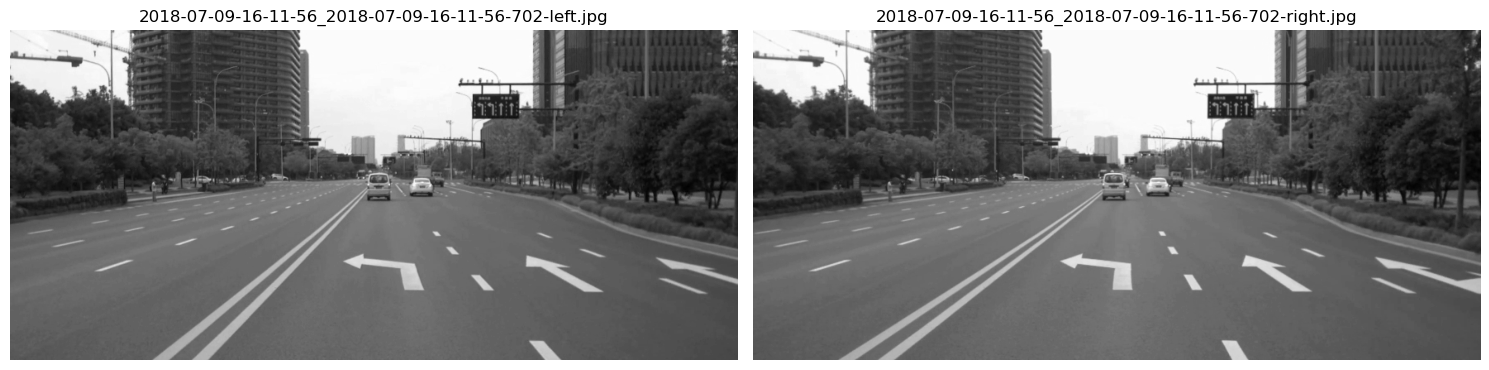

In [23]:
# img = randint(0, len(files)-1)
img = 0
a_img = cv2.imread(path + files[img][0])
a_img2 = cv2.imread(path + files[img][0], cv2.IMREAD_GRAYSCALE)
l_img = cv2.imread(path + files[img][1], cv2.IMREAD_GRAYSCALE)
r_img = cv2.imread(path + files[img][2], cv2.IMREAD_GRAYSCALE)
h, w = l_img.shape

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(l_img, cmap="gray")  
plt.title(files[img][1])
plt.axis('off')


plt.subplot(1,2,2)
plt.imshow(r_img, cmap="gray")  
plt.title(files[img][2])
plt.axis('off')

plt.tight_layout()
plt.show()

l_img = cv2.GaussianBlur(l_img,(5,5),0)
r_img = cv2.GaussianBlur(r_img,(5,5),0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(l_img, cmap="gray")  
plt.title(files[img][1])
plt.axis('off')


plt.subplot(1,2,2)
plt.imshow(r_img, cmap="gray")  
plt.title(files[img][2])
plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
def calc(h, w, r_img, func, compare_func):
    disp_map = np.zeros((h, w))
    for y in trange(BLOCK_SIZE, h-BLOCK_SIZE):
        for x in range(BLOCK_SIZE, w-BLOCK_SIZE):
            l_block = np.asarray(l_img[y:y + BLOCK_SIZE, 
                                    x:x + BLOCK_SIZE])
            min_index = compare_func(y, x, l_block, r_img, BLOCK_SIZE, SEARCH_SIZE, func)
            disp_map[y, x] = abs(min_index[1] - x)
    disp_map *= (255.0/disp_map.max())
    disp_map = disp_map.astype(int)
    return disp_map

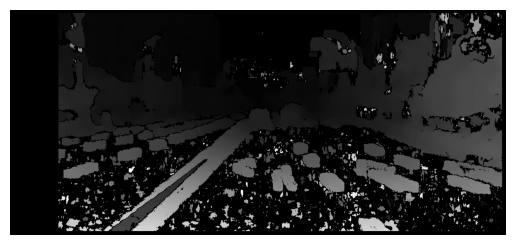

In [24]:
S_SIZE = 16*5
B_SIZE = 15
stereoBM = cv2.StereoBM_create(numDisparities=S_SIZE, blockSize=B_SIZE)
disparityBM = stereoBM.compute(l_img,r_img)
disparityBM = ((disparityBM - disparityBM.min()) / (disparityBM.max() - disparityBM.min())*255).astype(np.uint8)
plt.axis(False)
plt.imshow(disparityBM, cmap="gray")
plt.show()

327180


100%|██████████| 360/360 [04:16<00:00,  1.40it/s]


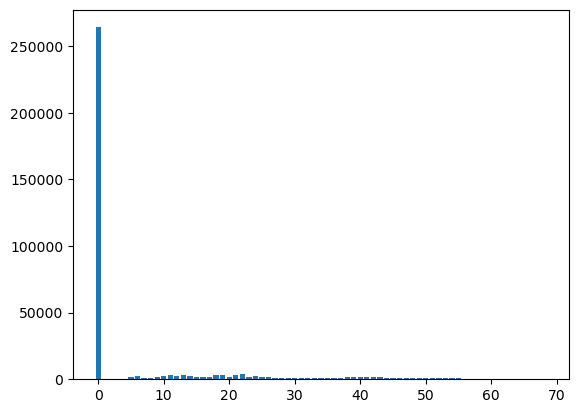

In [25]:
BLOCK_SIZE = 20
SEARCH_SIZE = 60
disp = calc(h, w, r_img, sum_square_diff, compare_blocks)
# disp = calc(h, w, r_img, sum_abs_diff, compare_blocks)
# disp = calc(h, w, r_img, zero_mean_sum_abs_diff, compare_blocks)
# disp = calc(h, w, r_img, norm_cross_cor, compare_blocks2)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(l_img, cmap="gray")  
plt.title(files[img][1])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(r_img, cmap="gray")  
plt.title(files[img][2])
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(a_img, cmap="gray")  
plt.title('Original ground truth image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(a_img2, cmap="gray")  
plt.title('Normalized ground truth image',)
plt.axis('off')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
plt.imshow(a_img2, cmap="gray")  
plt.title('Left image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(disp,  cmap="gray")  
plt.title('Right image',)
plt.axis('off')
plt.tight_layout()
plt.show()

k, c = np.unique(disp, return_counts=True)
plt.bar(k, c)
plt.show()
k2, c2 = np.unique(a_img2, return_counts=True)
plt.bar(k2, c2)
plt.show()